<a href="https://colab.research.google.com/github/AgnesElza/subscription-retention-analytics/blob/main/03_churn_prediction_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook continues from **03_exploratory_data_analysis.ipynb**, where we cleaned the KKBox dataset, engineered aggregated features, and performed churn pattern analysis.  
Here, we focus on **building and evaluating churn prediction models**, tuning thresholds for imbalanced data, and interpreting feature contributions using feature importance and SHAP.

In [ ]:
# Mounting Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare the dataset for modeling

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Path to your data
data_path = "/content/drive/MyDrive/data_science_projects/kkbox_project/data"
df = pd.read_csv(f"{data_path}/kkbox_merged_clean.csv")

print("Shape:", df.shape)
print(df.head())

Shape: (992931, 31)
                                           msno  is_churn  city  gender  \
0  waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=         1  18.0  female   
1  QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=         1  10.0    male   
2  fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=         1  11.0  female   
3  mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=         1  13.0  female   
4  XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=         1   3.0    male   

   registered_via registration_init_time  reg_year  reg_month  n_txns  \
0             9.0             2005-04-06      2005          4       2   
1             9.0             2005-04-07      2005          4      23   
2             9.0             2005-10-16      2005         10      10   
3             9.0             2005-11-02      2005         11       2   
4             9.0             2005-12-28      2005         12       8   

   cancel_rate  ...  last_gap_days  total_secs_sum  total_listens  \
0     0.000000  ...  

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   msno                      992931 non-null  object 
 1   is_churn                  992931 non-null  int64  
 2   city                      992931 non-null  float64
 3   gender                    992931 non-null  object 
 4   registered_via            992931 non-null  float64
 5   registration_init_time    992931 non-null  object 
 6   reg_year                  992931 non-null  int64  
 7   reg_month                 992931 non-null  int64  
 8   n_txns                    992931 non-null  int64  
 9   cancel_rate               992931 non-null  float64
 10  auto_renew_rate           992931 non-null  float64
 11  avg_plan_days             992931 non-null  float64
 12  std_plan_days             992931 non-null  float64
 13  share_30d                 992931 non-null  f

In [ ]:
# === Target & drop columns not usable for modeling ===
target = "is_churn"

# Columns to drop:
# - identifiers
# - raw dates (we already engineered features like last_gap_days)
# - anything with string IDs
drop_cols = [
    "msno",
    "registration_init_time",
    "last_txn_date",
    "last_expire_date",
    "last_activity_date"
]

X = df.drop(columns=drop_cols + [target], errors="ignore")
y = df[target]

# === Handle categoricals ===
cat_cols = ["gender", "registered_via", "city"]

# Quick one-hot encoding (get_dummies handles missing too)
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print("Final shape after encoding:", X.shape)
print("Churn distribution:\n", y.value_counts(normalize=True))

# === Train/Validation Split ===
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, "Validation size:", X_val.shape)
print("Churn ratio in train:", y_train.mean(), "Validation:", y_val.mean())


Final shape after encoding: (992931, 50)
Churn distribution:
 is_churn
0    0.936077
1    0.063923
Name: proportion, dtype: float64
Train size: (794344, 50) Validation size: (198587, 50)
Churn ratio in train: 0.06392318693160645 Validation: 0.0639216061474316


Churn ratio is consistent between splits.
Very imbalanced dataset, which means we’ll need techniques like class weighting, resampling, or using algorithms robust to imbalance (e.g., tree ensembles)

## Baseline model

Let’s build a baseline churn prediction pipeline.

We’ll use:

- Logistic Regression → simple linear baseline

- XGBoost → strong non-linear baseline (handles imbalance well with scale_pos_weight)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Helper: evaluate model
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    print("ROC AUC:", roc_auc_score(y_val, y_proba))
    print("PR AUC:", average_precision_score(y_val, y_proba))
    print("F1 Score:", f1_score(y_val, y_pred))
    print("\nClassification Report:\n", classification_report(y_val, y_pred, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

### Logistic Regression (baseline)

We’ll add class_weight='balanced' because of the skewed churn distribution.

In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
log_reg.fit(X_train, y_train)

print("---- Logistic Regression ----")
evaluate_model(log_reg, X_val, y_val)

---- Logistic Regression ----
ROC AUC: 0.42844344917096727
PR AUC: 0.05424721032273108
F1 Score: 0.07310263468344474

Classification Report:
               precision    recall  f1-score   support

           0      0.932     0.805     0.864    185893
           1      0.049     0.146     0.073     12694

    accuracy                          0.763    198587
   macro avg      0.491     0.476     0.468    198587
weighted avg      0.876     0.763     0.813    198587

Confusion Matrix:
 [[149586  36307]
 [ 10835   1859]]


### XGBoost (baseline tree model)

In [ ]:
# imbalance ratio
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = neg / pos
print("Scale pos weight:", scale_pos_weight)

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)

print("---- XGBoost ----")
evaluate_model(xgb, X_val, y_val)

Scale pos weight: 14.643775725229927


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:53:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


---- XGBoost ----
ROC AUC: 0.9788934615944872
PR AUC: 0.7918549585930555
F1 Score: 0.5880637636080871

Classification Report:
               precision    recall  f1-score   support

           0      0.997     0.912     0.952    185893
           1      0.425     0.953     0.588     12694

    accuracy                          0.915    198587
   macro avg      0.711     0.933     0.770    198587
weighted avg      0.960     0.915     0.929    198587

Confusion Matrix:
 [[169535  16358]
 [   594  12100]]


### ROC & PR Curve Plots

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def plot_curves(model, X_val, y_val, label="Model"):
    y_proba = model.predict_proba(X_val)[:, 1]

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12,5))

    # ROC subplot
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.3f})")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # --- PR Curve ---
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    pr_auc = auc(recall, precision)

    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"{label} (AP={pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.show()

Logistic Regression


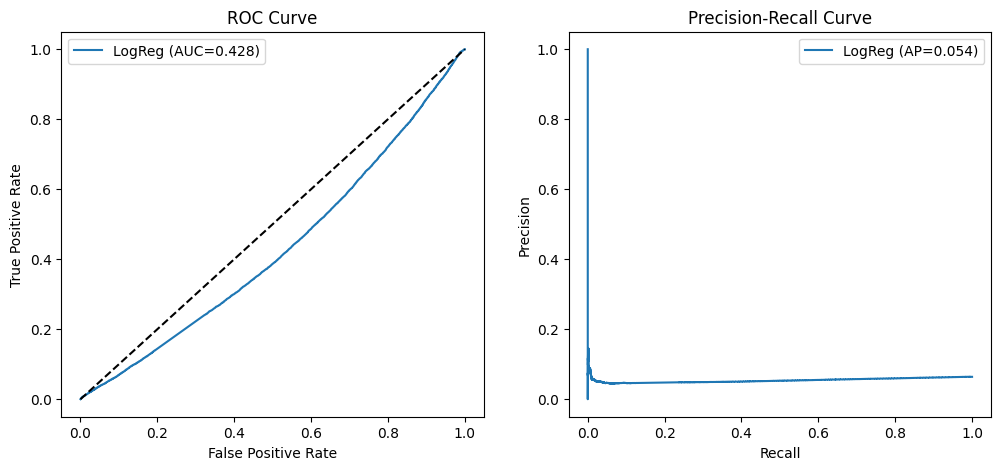

XGBoost


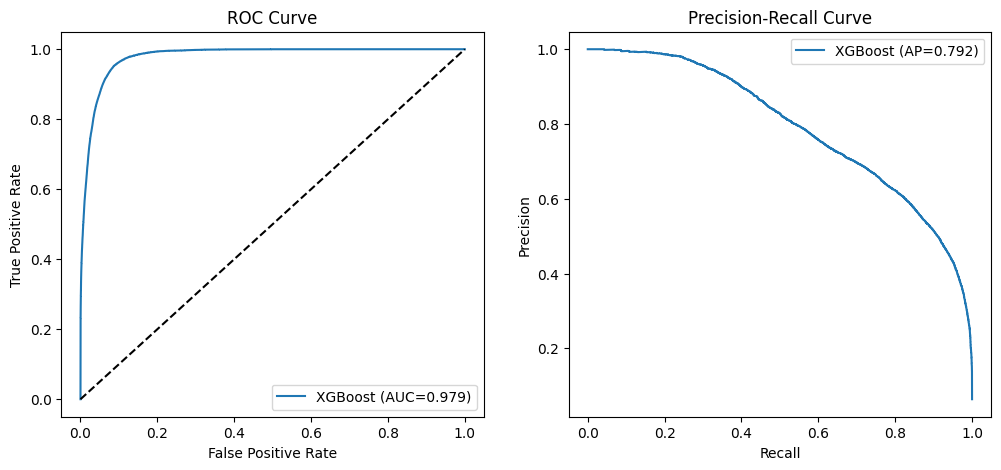

In [ ]:
print("Logistic Regression")
plot_curves(log_reg, X_val, y_val, label="LogReg")

print("XGBoost")
plot_curves(xgb, X_val, y_val, label="XGBoost")

Logistic regression completely failed to pick up meaningful signal from the features. It’s almost predicting noise.

XGBoost has captured clear, non-linear relationships and is highly effective.

Let's check which features XGBoost relied on most.

### XGBoost + SHAP

<Figure size 1000x800 with 0 Axes>

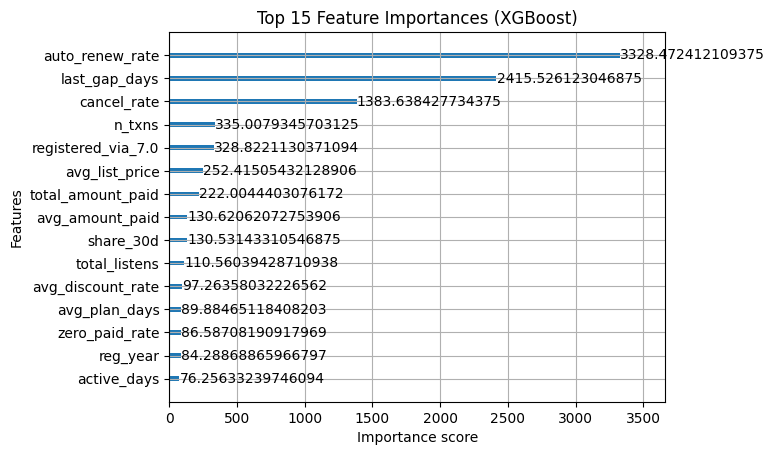

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
# Gain → how much each feature contributes to improving splits (good proxy for predictive power)
plt.figure(figsize=(10,8))
plot_importance(xgb, max_num_features=15, importance_type='gain')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

Subscription settings (auto-renew, canceling) and engagement (gaps, activity, transactions) are the strongest churn predictors. Price & discount patterns also matter.

We’ll use SHAP values to move beyond “importance” and see direction + shape of influence.

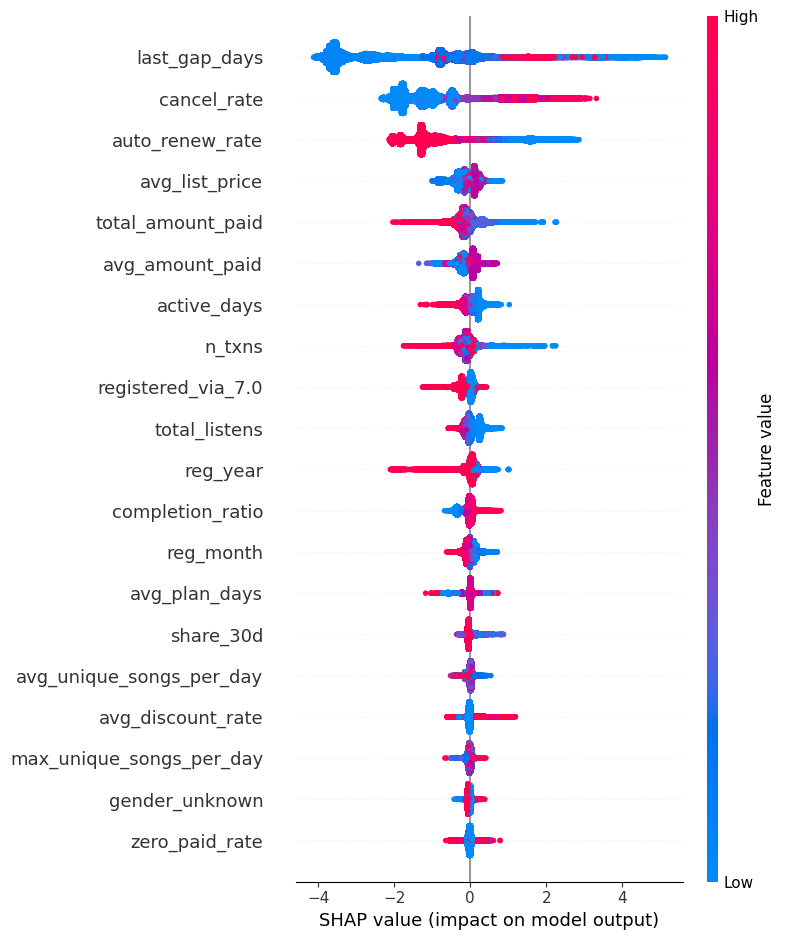

In [ ]:
import shap

# Explainer for XGBoost
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_val)

# Global feature impact (summary plot)
shap.summary_plot(shap_values, X_val)

- Users who stop engaging for long periods, cancel more often, and don’t auto-renew are the most at risk of churn.

- On the flip side, spending more and staying engaged significantly reduces churn.

- Demographics (like gender) and registration details play only a minor role → behavioral + payment features are what matter

### Thresold Tuning

In [ ]:
# Get predicted probabilities
y_pred_proba = xgb.predict_proba(X_val)[:,1]

# --- Precision-Recall Curve to find best threshold ---
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

In [ ]:
import numpy as np

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold by F1: {best_threshold:.3f}")
print(f"F1 at best threshold: {f1_scores[best_idx]:.3f}")

Best threshold by F1: 0.866
F1 at best threshold: 0.705


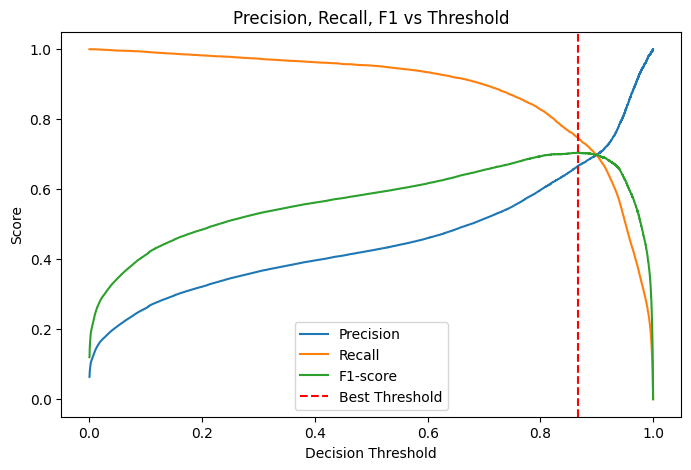

In [ ]:
# --- Plot Precision-Recall vs Threshold ---
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1_scores[:-1], label="F1-score")
plt.axvline(best_threshold, color='red', linestyle='--', label="Best Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold")
plt.legend()
plt.show()

### Threshold Tuning

Most classifiers output probabilities, not direct class labels.  
The default decision threshold is usually **0.5**, but with imbalanced datasets like churn prediction, this may not be optimal.

#### Why Threshold Tuning?
- **Precision**: How many predicted churners were actually churners.  
- **Recall**: How many actual churners we managed to catch.  
- **F1-score**: Harmonic mean of precision and recall — balances both.  

By sweeping across different probability thresholds (0 → 1), we can track how these metrics change and find the **optimal threshold** that maximizes performance.  

#### Results
- **Best Threshold (by F1-score): 0.866**  
- **F1-score at best threshold: 0.705**  

#### Interpretation
- At this threshold, the model achieves a better balance between precision and recall compared to the default 0.5.  
- A higher threshold means the model only flags churners when it’s very confident, reducing false positives but increasing the risk of missing some churners.  
- This tradeoff is critical in churn scenarios:  
  - **Lower threshold** → More churners caught (higher recall), but more false alarms (lower precision).  
  - **Higher threshold** → Fewer false alarms, but more missed churners.  

The choice of threshold should align with business costs:
- If missing a churner is very costly → lower threshold (prioritize recall).  
- If offering incentives unnecessarily is costly → higher threshold (prioritize precision).  


### Confusion Matrix

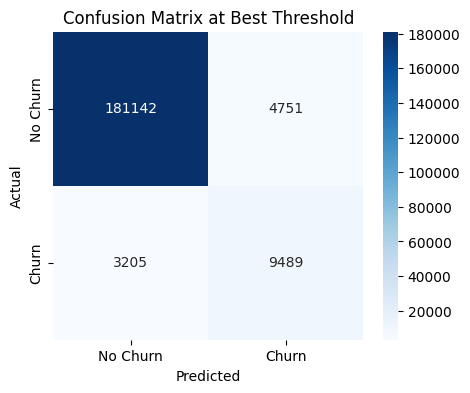

In [ ]:
import seaborn as sns

# --- Confusion Matrix at best threshold ---
y_pred_best = (y_pred_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_val, y_pred_best)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix at Best Threshold")
plt.show()

In [ ]:
# Business interpretation
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

True Negatives: 181142, False Positives: 4751, False Negatives: 3205, True Positives: 9489


### Confusion Matrix at Best Threshold

At the chosen decision threshold (0.866), the confusion matrix results are:

- **True Negatives (TN): 181,142** → Correctly predicted non-churners.  
- **False Positives (FP): 4,751** → Predicted churn but actually stayed (false alarms).  
- **False Negatives (FN): 3,205** → Predicted as staying but actually churned (missed churners).  
- **True Positives (TP): 9,489** → Correctly predicted churners.  

#### Interpretation
- The model is very accurate at identifying **non-churners** (high TN count).  
- It captures a **substantial number of churners** (TP = 9,489), though ~3.2k churners were missed (FN).  
- False positives are relatively small compared to the dataset, so the model avoids over-alerting.  

#### Business Implications
- **False Negatives (missed churners)**: Risk of losing customers who were not flagged for intervention.  
- **False Positives (false alarms)**: Leads to unnecessary retention offers but less costly than missing churners.  
- Depending on business priorities, the decision threshold can be adjusted:  
  - Lower threshold → catch more churners (higher recall), but risk more false positives.  
  - Higher threshold → fewer false positives, but more missed churners.  

This balance should be aligned with KKBox’s retention strategy — whether the cost of retention offers outweighs the loss of actual churners.


### Key Insights from Modeling
- **XGBoost** is far superior to Logistic Regression for churn prediction.  
- **Auto-renewal behavior, cancellation history, inactivity gaps, and engagement** are the strongest churn drivers.  
- SHAP analysis confirms:  
  - **Auto-renew ON → lowers churn probability**.  
  - **Long inactivity gaps & frequent cancellations → raise churn risk**.  
  - **Higher activity & consistent payments → reduce churn risk**.  

With modeling complete, we now move to causal insights churn happens and simulating interventions.